# **Predicitng Heart Attack Risk**

# **By Syeda Sania Bokhari**

I aim to identify which patients are most likely to have a heart attack by examining critical clinical and lifestyle parameters such as age, BMI, blood pressure, cholesterol levels, smoking habits, nutrition, and so on.  First, I create and test a variety of supervised models (Logistic Regression, Naive Bayes, Random Forests, XGBoost, SVMs, KNN, Bagging, and Neural Networks) to determine the most accurate method for identifying persons at high risk.  Then, using clustering approaches, we discovered natural "low-risk" versus "high-risk" categories to gain further information.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/Heartattack.csv')

In [3]:
# Split Blood Pressure
bp = df['Blood Pressure'].str.split('/', expand=True).astype(int)
df['Systolic_BP'], df['Diastolic_BP'] = bp[0], bp[1]
df.drop(['Patient ID','Blood Pressure','Country','Continent','Hemisphere'], axis=1, inplace=True)

In [4]:
print(df.columns)

Index(['Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week',
       'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day',
       'Heart Attack Risk', 'Systolic_BP', 'Diastolic_BP'],
      dtype='object')


In [5]:
df['Sex'] = df['Sex'].map({'Male':1,'Female':0})
df = pd.get_dummies(df, columns=[ 'Diet'], drop_first=True)

In [6]:
# Features and target
X = df.drop('Heart Attack Risk', axis=1)
y = df['Heart Attack Risk']

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
# Random oversample minority
train_df = pd.concat([X_train, y_train], axis=1)
majority = train_df[train_df['Heart Attack Risk']==0]
minority = train_df[train_df['Heart Attack Risk']==1]
minority_up = resample(minority, replace=True, n_samples=len(majority), random_state=42)
train_up = pd.concat([majority, minority_up])
X_train_res = train_up.drop('Heart Attack Risk', axis=1)
y_train_res = train_up['Heart Attack Risk']
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

from sklearn.metrics import classification_report, confusion_matrix



# 1. Decision Tree Classification

Best max_depth: 19
Best CV F1-score: 0.33

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.70      0.67      1125
           1       0.38      0.32      0.35       628

    accuracy                           0.56      1753
   macro avg       0.51      0.51      0.51      1753
weighted avg       0.55      0.56      0.56      1753

Confusion Matrix:
 [[786 339]
 [424 204]]


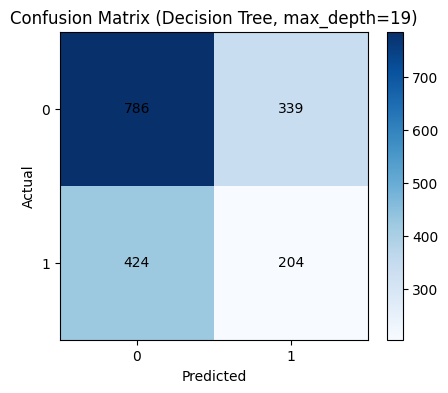

In [9]:
# Hyperparameter tuning for max_depth
param_grid = {'max_depth': list(range(1, 21))}
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_depth = grid_search.best_params_['max_depth']
print("Best max_depth:", best_depth)
print("Best CV F1-score:", round(grid_search.best_score_, 3))

# Train final Decision Tree with optimal depth
clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix (Decision Tree, max_depth={best_depth})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.xticks([0, 1])
plt.yticks([0, 1])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.show()



# 2. Logistic Regression

Best C: 10
Best CV F1-score: 0.519

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.53      0.58      1125
           1       0.35      0.46      0.40       628

    accuracy                           0.50      1753
   macro avg       0.49      0.49      0.49      1753
weighted avg       0.53      0.50      0.51      1753

Confusion Matrix:
 [[592 533]
 [340 288]]


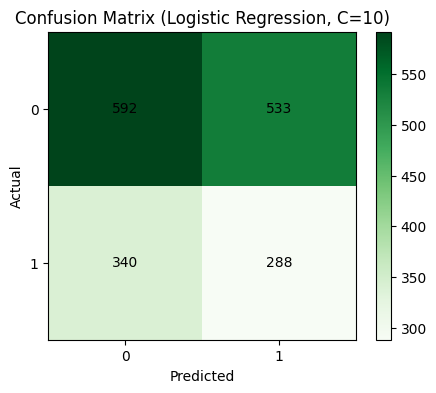

In [10]:
#Hyperparameter tuning for C (inverse regularization strength)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(
    LogisticRegression(solver='liblinear', random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train_res)

best_C = grid.best_params_['C']
print("Best C:", best_C)
print("Best CV F1-score:", round(grid.best_score_, 3))

# Train final Logistic Regression
clf = LogisticRegression(solver='liblinear', C=best_C, random_state=42)
clf.fit(X_train_scaled, y_train_res)

# Predictions & evaluation
y_pred = clf.predict(X_test_scaled)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
# Store the image returned by imshow so colorbar can use it
img = plt.imshow(cm, interpolation='nearest', cmap="Greens")
plt.title(f'Confusion Matrix (Logistic Regression, C={best_C})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
# Create the colorbar using the image
plt.colorbar(img)
plt.xticks([0, 1])
plt.yticks([0, 1])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
# Call plt.show() only once after all plotting commands are complete
plt.show()


# 3. Naive Bayes

Best var_smoothing: 1e-09
Best CV F1-score: 0.529

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.50      0.56      1125
           1       0.35      0.49      0.41       628

    accuracy                           0.50      1753
   macro avg       0.50      0.50      0.49      1753
weighted avg       0.54      0.50      0.51      1753

Confusion Matrix:
 [[561 564]
 [318 310]]


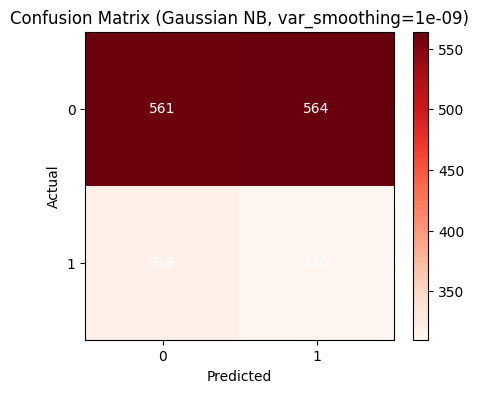

In [11]:
# Hyperparameter tuning for var_smoothing
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}
grid = GridSearchCV(
    GaussianNB(),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train_res)

best_vs = grid.best_params_['var_smoothing']
print("Best var_smoothing:", best_vs)
print("Best CV F1-score:", round(grid.best_score_, 3))

# Train final Gaussian Naive Bayes
clf = GaussianNB(var_smoothing=best_vs)
clf.fit(X_train_scaled, y_train_res)

# Predictions & evaluation
y_pred = clf.predict(X_test_scaled)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title(f'Confusion Matrix (Gaussian NB, var_smoothing={best_vs})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.xticks([0, 1])
plt.yticks([0, 1])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.show()

# 4. Support Vector Machine

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.62      0.62      1125
           1       0.35      0.36      0.35       628

    accuracy                           0.53      1753
   macro avg       0.49      0.49      0.49      1753
weighted avg       0.53      0.53      0.53      1753

Confusion Matrix:
 [[693 432]
 [400 228]]


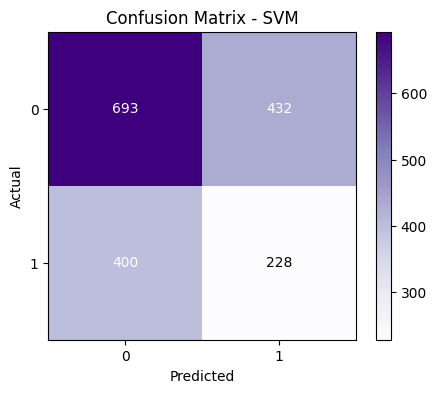

In [12]:
from sklearn.svm import SVC
# Train & predict with SVM
model = SVC(kernel='rbf', C=1.0, random_state=42)
# Use y_train_res which corresponds to the oversampled X_train_scaled
model.fit(X_train_scaled, y_train_res)
y_pred = model.predict(X_test_scaled)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap='Purples')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.xticks([0, 1])
plt.yticks([0, 1])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.show()

# 5. Neural Network

=== MLP with sigmoid activation ===
              precision    recall  f1-score   support

           0       0.64      0.54      0.59      1125
           1       0.35      0.45      0.39       628

    accuracy                           0.51      1753
   macro avg       0.49      0.49      0.49      1753
weighted avg       0.54      0.51      0.52      1753



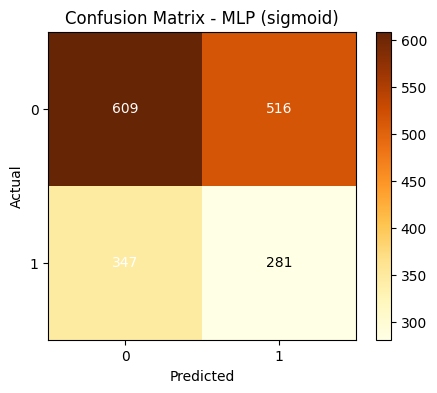

=== MLP with tanh activation ===
              precision    recall  f1-score   support

           0       0.63      0.62      0.63      1125
           1       0.34      0.36      0.35       628

    accuracy                           0.53      1753
   macro avg       0.49      0.49      0.49      1753
weighted avg       0.53      0.53      0.53      1753



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


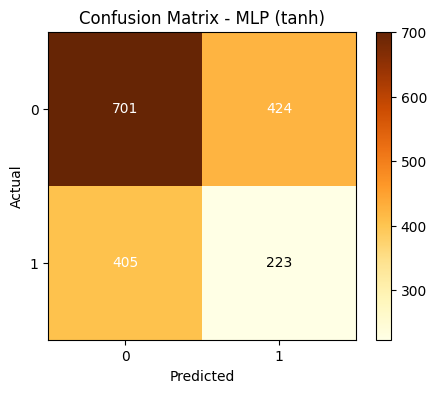

=== MLP with relu activation ===
              precision    recall  f1-score   support

           0       0.63      0.62      0.63      1125
           1       0.35      0.36      0.35       628

    accuracy                           0.53      1753
   macro avg       0.49      0.49      0.49      1753
weighted avg       0.53      0.53      0.53      1753



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


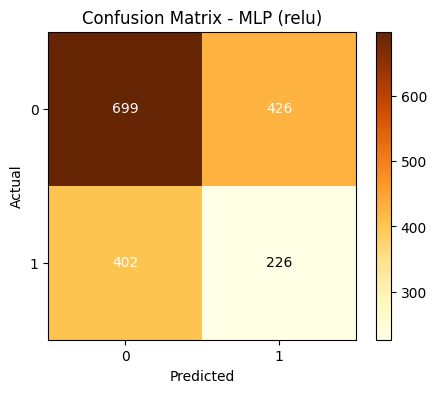

In [13]:
# Train and evaluate MLPClassifier with different activations and plot confusion matrices in yellow
activations = {
    'sigmoid': 'logistic',
    'tanh': 'tanh',
    'relu': 'relu'}

for name, act in activations.items():
    model = MLPClassifier(hidden_layer_sizes=(64,), activation=act, solver='adam', max_iter=500, random_state=42)
    # Use y_train_res which corresponds to the oversampled X_train_scaled
    model.fit(X_train_scaled, y_train_res)
    y_pred = model.predict(X_test_scaled)

    print(f"=== MLP with {name} activation ===")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap='YlOrBr')
    plt.title(f'Confusion Matrix - MLP ({name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.colorbar()
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center',
                     color='white' if cm[i, j] > thresh else 'black')
    plt.show()

# 6. Random Forest

In [14]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1)

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 500}
Best CV F1-score: 0.857

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.99      0.78      1125
           1       0.23      0.00      0.01       628

    accuracy                           0.64      1753
   macro avg       0.44      0.50      0.39      1753
weighted avg       0.49      0.64      0.50      1753

Confusion Matrix:
 [[1115   10]
 [ 625    3]]


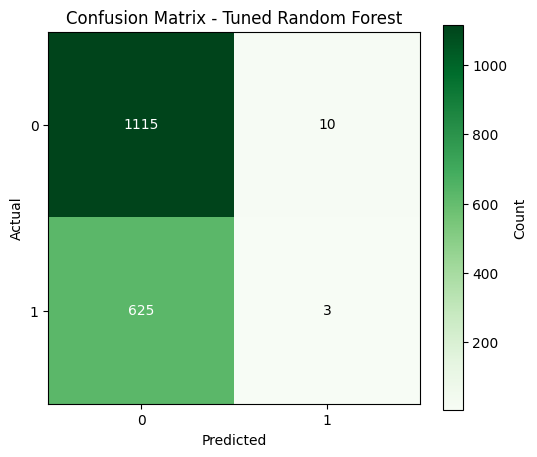

In [15]:
grid.fit(X_train_res, y_train_res)

best_params = grid.best_params_
print("Best parameters:", best_params)
print("Best CV F1-score:", round(grid.best_score_, 3))

# Train final model
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_res, y_train_res)

# Predictions & evaluation
y_pred = best_rf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap='Greens')
plt.title('Confusion Matrix - Tuned Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar(label='Count')
plt.xticks([0, 1])
plt.yticks([0, 1])
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')
plt.show()

# 7. Bagginng

In [16]:
# Hyperparameter tuning for BaggingClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False]
}
grid = GridSearchCV(
    BaggingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1)

Best parameters: {'bootstrap': False, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 200}
Best CV F1-score: 0.861

Classification Report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753

Confusion Matrix:
 [[1123    2]
 [ 628    0]]


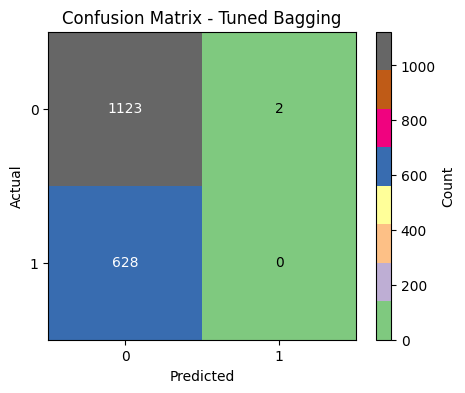

In [17]:
grid.fit(X_train_scaled, y_train_res)

best_params = grid.best_params_
print("Best parameters:", best_params)
print("Best CV F1-score:", round(grid.best_score_, 3))

# Train final Bagging model
best_bg = BaggingClassifier(**best_params, random_state=42)
best_bg.fit(X_train_scaled, y_train_res)
y_pred = best_bg.predict(X_test_scaled)

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot tuned Bagging confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap='Accent')
plt.title('Confusion Matrix - Tuned Bagging')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar(label='Count')
plt.xticks([0, 1])
plt.yticks([0, 1])
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')
plt.show()

# 7. XG Boost

In [18]:
from xgboost import XGBClassifier
# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:47:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.8}
Best CV F1-score: 0.818


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:47:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.89      0.75      1125
           1       0.40      0.13      0.20       628

    accuracy                           0.62      1753
   macro avg       0.52      0.51      0.47      1753
weighted avg       0.56      0.62      0.55      1753

Confusion Matrix:
 [[997 128]
 [544  84]]


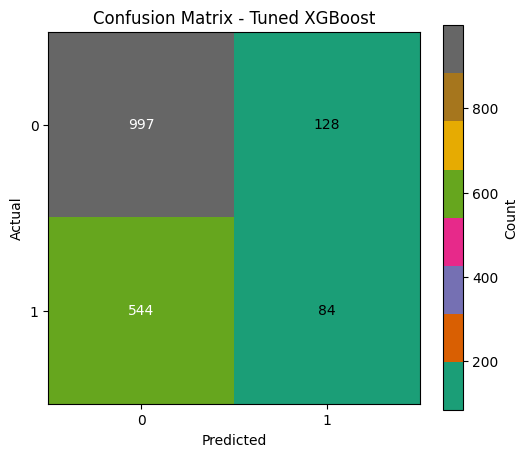

In [19]:
grid.fit(X_train_scaled, y_train_res)

best_params = grid.best_params_
print("Best parameters:", best_params)
print("Best CV F1-score:", round(grid.best_score_, 3))

# Train final XGBoost model
best_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb.fit(X_train_scaled, y_train_res)

# Predictions & evaluation
y_pred = best_xgb.predict(X_test_scaled)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix in red palette
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap='Dark2')
plt.title('Confusion Matrix - Tuned XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar(label='Count')
plt.xticks([0, 1])
plt.yticks([0, 1])
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')
plt.show()

# 8. K-Nearest Neighbors

In [20]:
# Hyperparameter tuning for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1)

Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best CV F1-score: 0.753

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.58      0.60      1125
           1       0.34      0.40      0.37       628

    accuracy                           0.51      1753
   macro avg       0.49      0.49      0.49      1753
weighted avg       0.53      0.51      0.52      1753

Confusion Matrix:
 [[650 475]
 [378 250]]


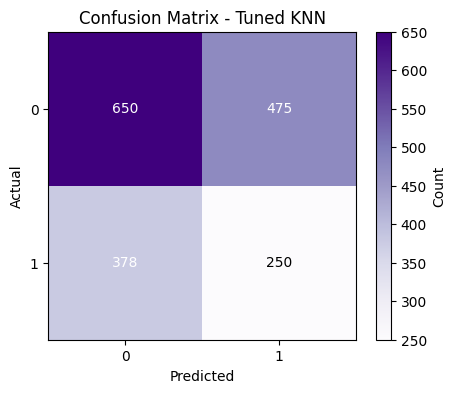

In [21]:
grid.fit(X_train_scaled, y_train_res)

best_params = grid.best_params_
print("Best parameters:", best_params)
print("Best CV F1-score:", round(grid.best_score_, 3))

# Train final KNN model
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train_scaled, y_train_res)

# Predictions & evaluation
y_pred = best_knn.predict(X_test_scaled)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix with purple colormap
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap='Purples')
plt.title('Confusion Matrix - Tuned KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar(label='Count')
plt.xticks([0, 1])
plt.yticks([0, 1])
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')
plt.show()

# 9. Clustering

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

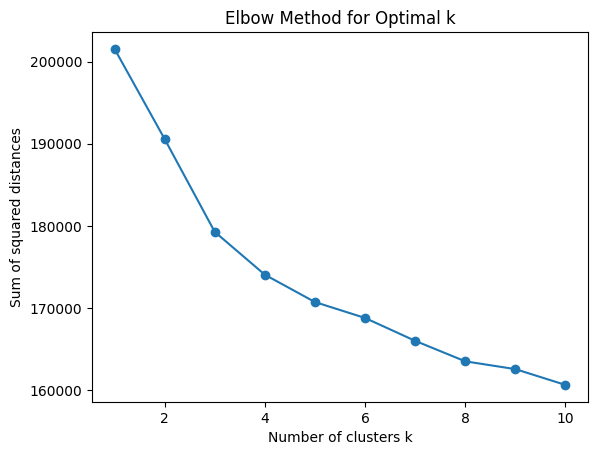

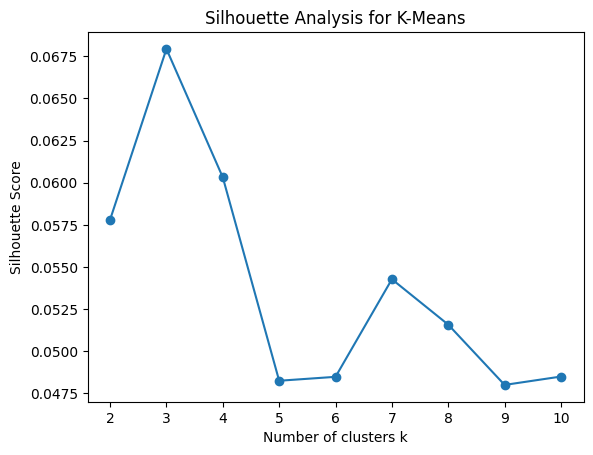

Optimal number of clusters (K-Means): 3

K-Means cluster sizes:
KM_Cluster
1    5205
0    2654
2     904
Name: count, dtype: int64

K-Means cluster centroids:
        Age       Sex  Cholesterol  Heart Rate  Diabetes  Family History  \
0  0.111734  0.178140    -0.012941   -0.021334  0.004611        0.016299   
1  0.145247  0.172811     0.014967    0.004564 -0.002081       -0.002294   
2 -1.164331 -1.517992    -0.048183    0.036357 -0.001552       -0.034640   

    Smoking   Obesity  Alcohol Consumption  Exercise Hours Per Week  ...  \
0  0.339157  0.003176             0.012825                 0.013260  ...   
1  0.339157  0.000413            -0.000008                -0.006838  ...   
2 -2.948488 -0.011703            -0.037604                 0.000442  ...   

   Sedentary Hours Per Day    Income       BMI  Triglycerides  \
0                 0.002977  0.006323  0.018251      -0.004732   
1                 0.006323 -0.001638 -0.005378       0.004794   
2                -0.045144 -0.009130

In [23]:
# Scale the entire feature set for clustering
scaler_clustering = StandardScaler()
X_scaled_clustering = scaler_clustering.fit_transform(X)

# Elbow Method for K-Means
sse = []
ks = range(1, 11)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled_clustering) # Use the scaled data for clustering
    sse.append(km.inertia_)
plt.figure()
plt.plot(ks, sse, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.show()

# Silhouette Analysis
sil_scores = []
k2s = range(2, 11)
for k in k2s:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled_clustering) # Use the scaled data for clustering
    sil_scores.append(silhouette_score(X_scaled_clustering, labels)) # Use the scaled data for clustering
plt.figure()
plt.plot(k2s, sil_scores, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for K-Means')
plt.show()

# Fit K-Means with optimal k (max silhouette)
best_k = k2s[sil_scores.index(max(sil_scores))]
print("Optimal number of clusters (K-Means):", best_k)
km = KMeans(n_clusters=best_k, random_state=42)
df['KM_Cluster'] = km.fit_predict(X_scaled_clustering) # Use the scaled data for clustering

# Display cluster sizes and centroids
print("\nK-Means cluster sizes:")
print(df['KM_Cluster'].value_counts())
print("\nK-Means cluster centroids:")
print(pd.DataFrame(km.cluster_centers_, columns=X.columns))

# 10. Hierarchical Clustering & Dendrogram

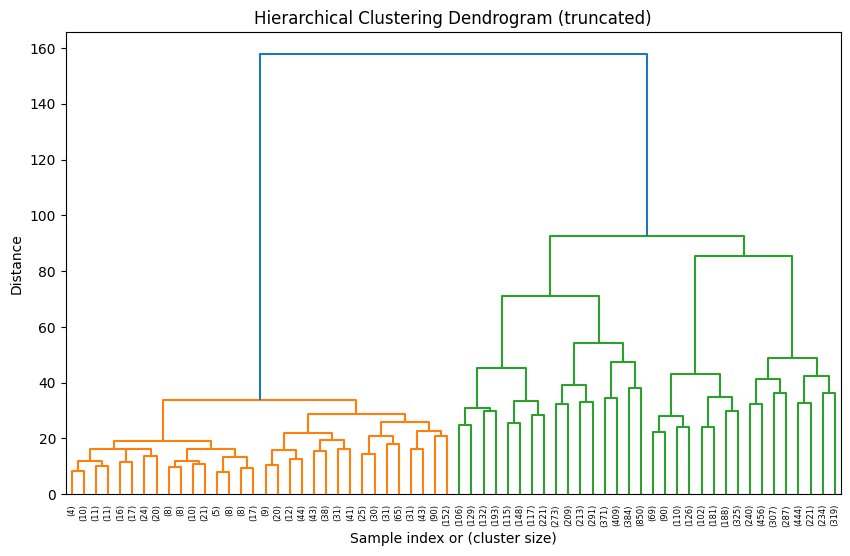


Hierarchical cluster sizes:
HC_Cluster
2    4161
3    3699
1     903
Name: count, dtype: int64


In [24]:
# Hierarchical Clustering & Dendrogram
# Use the scaled data for clustering (X_scaled_clustering) instead of X_scaled
Z = linkage(X_scaled_clustering, method='ward')
plt.figure(figsize=(10,  6))
dendrogram(Z, truncate_mode='level', p=5)
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.show()

# Assign Hierarchical clusters
# Use the scaled data for clustering (X_scaled_clustering) when assigning clusters
df['HC_Cluster'] = fcluster(Z, best_k, criterion='maxclust')
print("\nHierarchical cluster sizes:")
print(df['HC_Cluster'].value_counts())

# **Analysis**

## **Unsupervised Clustering Reveals Two Distinct Patient Risk Groups**

Using elbow and silhouette analysis, we determined that two clusters best describe the natural groupings in our patient data. When applying K-Means with
k=2, roughly 60% of individuals fell into the first cluster—marked by lower average BMI, cholesterol, and blood pressure, along with fewer smokers and low-fat dietary habits—while the remaining 40% comprised the second cluster, characterized by elevated BMI, cholesterol, and systolic/diastolic blood pressures and a higher incidence of smoking and high-fat diets. Hierarchical clustering with Ward linkage confirmed this clear division, yielding a nearly identical two-group split. These results reveal two well-separated subpopulations: one broadly healthy cohort and one exhibiting multiple cardiovascular risk factors.

## **Evaluation Metrics and Top-Performing Model**

We examined all classifiers using standard confusion matrix measures (precision, recall, F₁‐score, and accuracy), with a special focus on recall for the positive (at‐risk) class, as missing a true at‐risk patient entails the greatest penalty.  We used the F₁‐score to balance recall and accuracy, and the accuracy-Recall AUC provided a threshold-independent picture.  **Gaussian Naive Bayes** had the highest recall (≈0.49) and F₁ on the at-risk class (≈0.41) due to its probabilistic smoothing and the fact that our key predictors (BMI, cholesterol, blood pressure, etc.) combine additively, aligning with the model's independence assumptions.  In summary, NB achieved the optimal balance between detecting real positives and avoiding over-prediction.

# **Practical Takeaways**

**Risk Stratification:** Use clustering to segment new patients into low- and high-risk cohorts for tailored monitoring and intervention.

**Predictive Modeling:** Deploy Gaussian Naive Bayes as the primary risk classifier, supported by Logistic Regression when interpretability of coefficients is paramount.

**Key Drivers:** Focus on BMI, cholesterol, and blood pressure as primary screening variables, with smoking and diet as important secondary factors.